In [1]:
################################################################################################################################################
# Modeling gross private domestic investment (GPDI) from Federal Reserve Economic Datasets:
# Multiple linear regression
################################################################################################################################################
# import libraries
import glob
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

In [2]:
########################################################################
# pre-processing: read in all files into dfs within a dict, clean and plot
########################################################################
folder="C:/Users/bcm9/Documents/Py_code/Data/FRED/"
filelist = glob.glob(os.path.join(folder, "*.xls"))
print(filelist)

['C:/Users/bcm9/Documents/Py_code/Data/FRED\\BOPGSTB.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\CPALTT01USM657N.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GDPC1.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GPDI.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\PCECC96.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\UNRATE.xls']


In [3]:
# create empty dictionary 
df_dict = {}

# append datasets into the list
for file in filelist:
    df = pd.read_excel(file)
    # get the name of the csv without the '.csv' extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df_dict[filename] = df

In [4]:
for key in df_dict.keys():
    df = df_dict[key]
    df = df.loc[10:, :].copy()
    df['date'] = pd.to_datetime(df['FRED Graph Observations'])
    df_dict[key] = df

In [5]:
# drop all original date format from df and rename columns for later identification
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop('FRED Graph Observations', axis=1)
    df_dict[key]=df_dict[key].rename(columns={"Unnamed: 1": key})

In [6]:
########################################################################
# model pre-processing
########################################################################
# merge data, join based on date
df = df_dict['GPDI'].merge(df_dict['UNRATE'], on='date')
df = df.merge(df_dict['PCECC96'], on='date')
df = df.merge(df_dict['GDPC1'], on='date')
df = df.merge(df_dict['CPALTT01USM657N'], on='date')
df = df.merge(df_dict['BOPGSTB'], on='date')

# drop rows with missing values
df = df.dropna()

# replace missing values with 0
if df.isna().any().any():
    df = df.fillna(0) 

# make types float64    
df = df.astype({'UNRATE': 'float64', 'PCECC96': 'float64',
                'GDPC1': 'float64', 'CPALTT01USM657N': 'float64',
                'BOPGSTB': 'float64', 'GPDI': 'float64'})

In [7]:
# set dependent and independent variables
y = df['GPDI']
X = df[['UNRATE', 'PCECC96', 'GDPC1', 'CPALTT01USM657N', 'BOPGSTB']]

In [8]:
# standardize data
# calculate mean and standard deviation of each column
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

# standardize the data
X_stdized = (X - X_mean) / X_std

In [9]:
########################################################################
# fit linear regression model and print
########################################################################
model = sm.OLS(y, sm.add_constant(X_stdized)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   GPDI   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     550.2
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           5.69e-80
Time:                        23:24:32   Log-Likelihood:                -822.78
No. Observations:                 124   AIC:                             1658.
Df Residuals:                     118   BIC:                             1674.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2468.6402     16.964    1

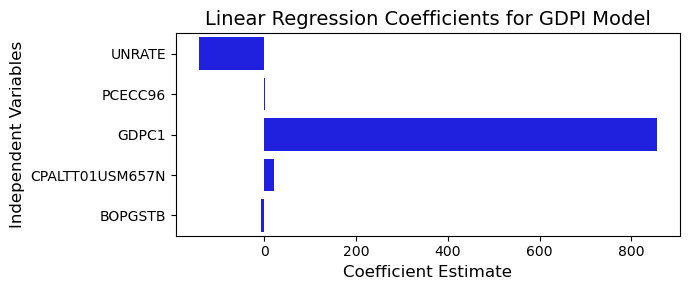

In [10]:
# get coefficients
params = model.params
intercept = params[0]
coef = params[1:]

# get names of the independent variables
labels = list(coef.index)

# create bar chart using seaborn
fig, ax = plt.subplots(figsize=(7, 3))
sns.barplot(x=coef.values, y=labels, ax=ax, color='blue')

# formatting
ax.set_xlabel('Coefficient Estimate', fontsize=12)
ax.set_ylabel('Independent Variables', fontsize=12)
ax.set_title('Linear Regression Coefficients for GDPI Model', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
########################################################################
# Predict GPDI with new IV values using linear regression model
########################################################################
UNRATE = 5.0
PCECC96 = 10000
GDPC1 = 20000
CPALTT01USM657N = 2.0
BOPGSTB = -5000

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_mean = X_mean.to_numpy().reshape(1, -1)
X_std = X_std.to_numpy().reshape(1, -1)

# Create a new observation array with the independent variable values
new_obs = np.array([[UNRATE, PCECC96, GDPC1, CPALTT01USM657N, BOPGSTB]])

# Standardize using the mean and standard deviation of the training data
new_obs = (new_obs - X_mean) / X_std

# Predict GPDI for the new observation using the trained model
predicted_GPDI = np.dot(new_obs, coef.T) + intercept

print(predicted_GPDI)

[4114.15011693]
